<a href="https://colab.research.google.com/github/Joonqi/Section_Projects/blob/main/S2_WaterPotability_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['image.cmap'] = 'Blues'
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import statsmodels.api as sm
from scipy.stats import randint, uniform
import shap

df = pd.read_csv('C:/Users/NAUGHT/PY/AIB/Dataset/water_potability.csv')

## 프로젝트 절차:
### 프로젝트 노트북 및 발표 영상의 흐름을 정하는 것은 자유이나 아래의 내용이 포함이 되있으셔야 합니다.

1) 데이터 선정 이유 및 문제 정의 
 데이터를 선정할 때에는 반드시 왜 해당 데이터를 선택했는지에 대해 황준기님의 이유를 자세히 설명해주셔야 합니다. 데이터셋 선정이 끝났다면 어떤 유형의 문제로 (분류 / 회귀) 접근할지도 결정합니다.

2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
 데이터를 선정함과 동시에 데이터를 통해서 내가 무엇을 해볼 수 있을지 가설을 세우는 것이 중요합니다. 가설은 쓸모 있어야 한다는 사실을 잊지마시길 바랍니다.
 데이터 기반의 사고방식, data-driven의 마음가짐을 section1과 2에서 배웠습니다. 이번에는 그것들을 심화시켜서 문제 해결을 시도 해봅니다.

태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.
- 해당 특성을 target으로 지정한 이유를 설명하세요
- 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요

3) EDA와 데이터 전처리
 가설을 정했고 베이스라인을 만들었다면 데이터의 탐색 및 가공을 시작해봅니다. 바로 적용이 될 수 있는 데이터도 있겠지만, 대부분의 데이터는 전처리 작업이 필요합니다.
데이터 전처리를 통해 할 수 있는 것은 다양하지만 다음을 시도해볼 수 있습니다.

- EDA
- Feature Engineering
- 데이터의 정규화
- 노이즈 제거
- 결측치 제거 혹은 대체
- 데이터 밸런스
- 그 외

4) 머신러닝 방식 적용 및 교차검증
 데이터의 탐색과 전처리 작업이 끝났다면 모델링을 통해 베이스라인과의 성능 비교를 해봅니다.

- Linear / Tree-based / Ensemble 모델을 학습하세요. (다양하게 시도해보시는 걸 추천합니다.)
- 평가지표를 계산 후 베이스라인과 비교해보세요.

어느정도 성능이 나왔다면, 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인해봅니다.<br>
모델 성능을 개선하기 위한 다양한 방법을 적용해보세요.
- Hyperparameter tuning, etc.

최소 2개 이상의 모델을 만들어서 validation 점수를 보고하세요.<br>
- 최종 모델의 test 점수를 보고하세요.

태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.
- 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
- 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
최종 모델에 관해 설명하세요.

5) 머신러닝 모델 해석
 프로젝트에서 가장 중요하다고 볼 수 있는 부분 입니다. 우리는 SHAP, PDP 등을 통해서 모델이 관측치를 어떤 특성을 활용했거나, 어떤 특성이 타겟에 영향을 끼쳤는지 등을 해석하는 방법에 대해서 배웠습니다.
여러분의 프로젝트에도 이러한 해석 방법을 활용해 머신러닝 모델을 비전문가라도 조금 더 쉽게 이해하고 접근할 수 있도록 해주셔야 합니다.

PDP, SHAP을 활용하여 최종 모델을 설명합니다
시각화는 "설명"이 제일 중요합니다.
태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다.
- 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
- 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?

<br><br>
# Section 2 Project

## 1) Data Description
### 수질 데이터셋
<br>
Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. This is important as a health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions.
<br>

특정 수역의 성분 분석 결과입니다. 이 정보를 통해서 이 물이 식수로 활용 가능한지 여부를 파악하고자 합니다.

### 1. pH value 수소이온농도:
PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. **WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.**
### 2. Hardness 수질 경도:
Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.
### 3. Solids (Total dissolved solids - TDS) 총용존고형물:
Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. **Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.**
### 4. Chloramines 결합염소:
Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. **Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.**
### 5. Sulfate 황산염:
Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). **It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.**

### 6. Conductivity 전도도:
Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. **According to WHO standards, EC value should not exceeded 400 μS/cm.**

### 7. Organic_carbon 전유기탄소:
Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. **According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.**

### 8. Trihalomethanes 트라이할로메테인:
THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. **THM levels up to 80 ppm is considered safe in drinking water.**
### 9. Turbidity 탁도:
The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. **The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.**

In [ ]:
print(df.shape)
df.head(10)

(3276, 10)


ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0        NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2   8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8        NaN  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
5        8.399735        54.917862   2.559708           0  
6       13.789695        84.603556   2.672989           0  
7       12.363817        62.798309   4.401425           0  
8       12.706049        53.928846   3.595017           0  
9       17.927806        71.976601   4.370562           0

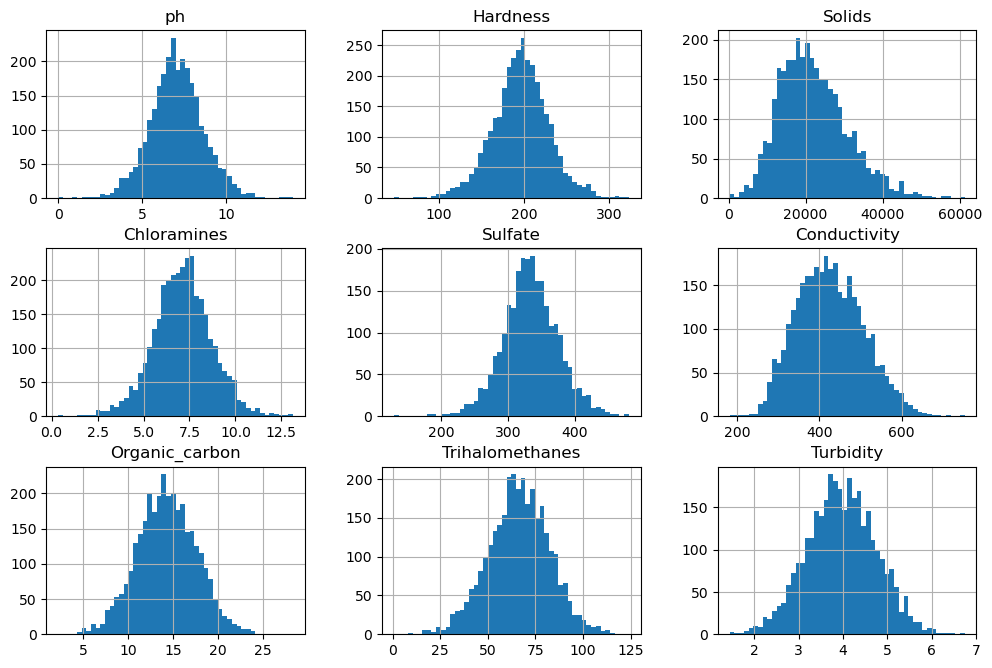

In [ ]:
# 특성별 분포 확인
df.loc[:,:'Turbidity'].hist(figsize=(12, 8), bins=50);
# -> 정규분포와 유사 => StandardScaler 활용

In [ ]:
# 결측치 확인
df.isna().sum()
# -> 평균으로 결측치 입력

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

#### Potability (Target) :
Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.  
예측하고자 하는 타겟 : 이 물이 마셔도 안전한 물인가?

In [ ]:
# yes / no 를 판단하는 분류 문제로 접근
df.Potability.value_counts(normalize=True)

0    0.60989
1    0.39011
Name: Potability, dtype: float64

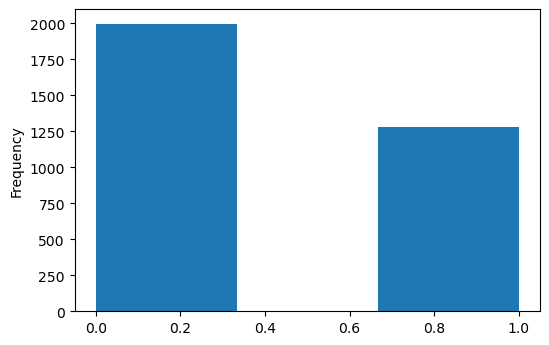

In [ ]:
df.Potability.plot(kind='hist', bins=3);

In [ ]:
# 만들 모델:
# 여러가지 수질 측정 지표가 있을 때 이 물을 먹어도 좋은지 분류하는 ML 모델

## 2) EDA

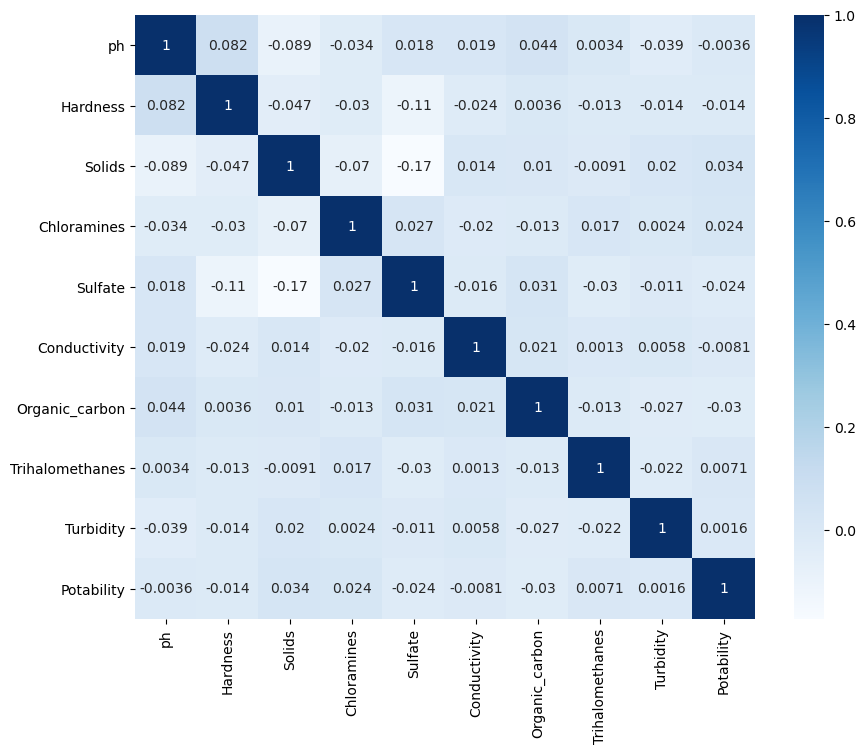

In [ ]:
# 특성 간 상관계수
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(),
            annot = True, 
            cmap='Blues');

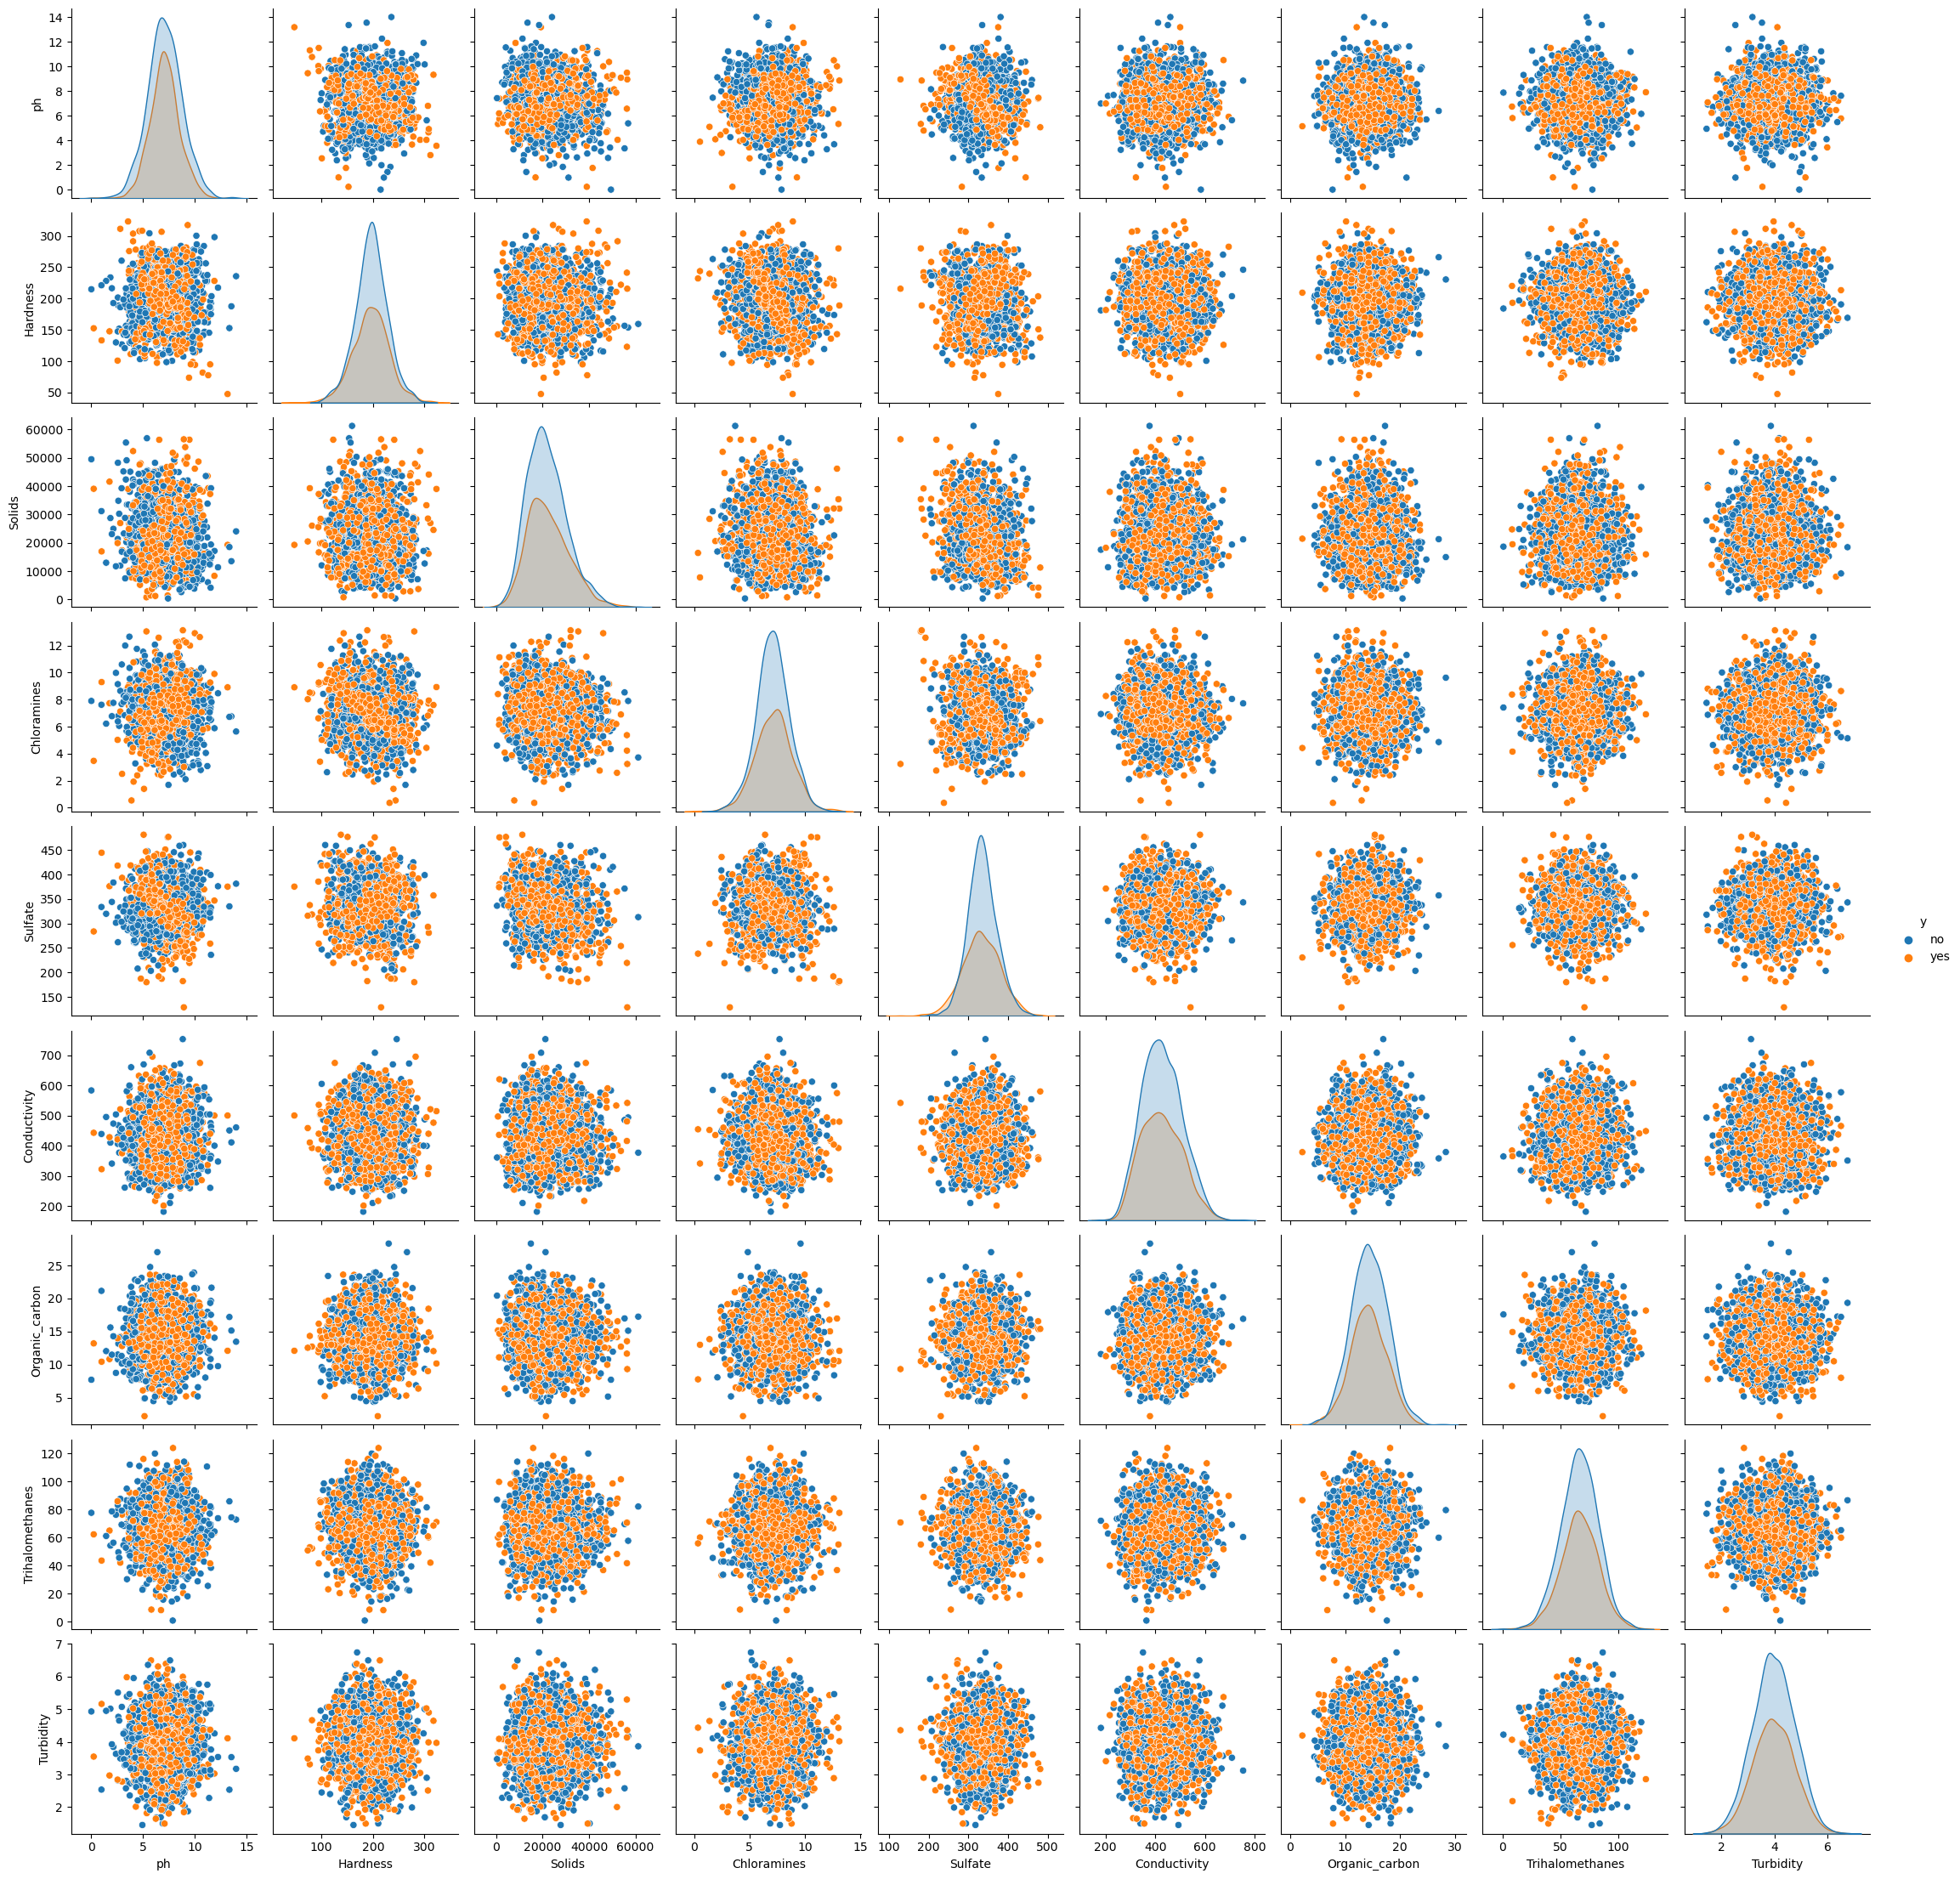

In [ ]:
# 0과 1을 나눠서 산점도, 분포도
y = df.Potability.replace([0, 1], ['no', 'yes'])
data = df.copy()
data['y'] = y
sns.pairplot(data.drop('Potability', axis=1), hue = 'y', data=data);

In [ ]:
df.groupby('Potability').describe().loc(axis=1)[:,['count','mean','std']].T

Potability                        0             1
ph              count   1684.000000   1101.000000
                mean       7.085378      7.073783
                std        1.683499      1.448048
Hardness        count   1998.000000   1278.000000
                mean     196.733292    195.800744
                std       31.057540     35.547041
Solids          count   1998.000000   1278.000000
                mean   21777.490788  22383.991018
                std     8543.068788   9101.010208
Chloramines     count   1998.000000   1278.000000
                mean       7.092175      7.169338
                std        1.501045      1.702988
Sulfate         count   1510.000000    985.000000
                mean     334.564290    332.566990
                std       36.745549     47.692818
Conductivity    count   1998.000000   1278.000000
                mean     426.730454    425.383800
                std       80.047317     82.048446
Organic_carbon  count   1998.000000   1278.000000
                mean      14.364335     14.160893
                std        3.334554      3.263907
Trihalomethanes count   1891.000000   1223.000000
                mean      66.303555     66.539684
                std       16.079320     16.327419
Turbidity       count   1998.000000   1278.000000
                mean       3.965800      3.968328
                std        0.780282      0.780842

In [ ]:
# 데이터에 표면적으로 드러나는 상관관계가 거의 없다.
# 정확하게 분류하는 것이 꽤 어려운 데이터셋

## 3) Preprocessing

In [ ]:
y = df.Potability
X = df.drop('Potability', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
print(X_train.shape, X_test.shape)

(2620, 9) (656, 9)


In [ ]:
# 데이터 누수문제를 방지하기 위해 파이프라인 활용
transform = make_pipeline(
    SimpleImputer(),
    StandardScaler())
    
features = X.columns
Xt_train = pd.DataFrame(transform.fit_transform(X_train), index=y_train.index, columns=features)
Xt_test = pd.DataFrame(transform.transform(X_test), index=y_test.index, columns=features)

In [ ]:
# Baseline model

y_train.value_counts(normalize=True)
y_base = [0] * len(y_test)
print(classification_report(y_test, y_base, zero_division=0))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



## 4) Machine Learning Modeling

In [ ]:
# Logistic Regression
lr_model = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression())

lr_model.fit(X_train, y_train)
y_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_lr, zero_division=0))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       412
           1       0.00      0.00      0.00       244

    accuracy                           0.63       656
   macro avg       0.31      0.50      0.39       656
weighted avg       0.39      0.63      0.48       656



In [ ]:
# Decision Tree 
dt_model = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier())
dt_model.fit(X_train, y_train);
y_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_dt))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65       412
           1       0.44      0.49      0.47       244

    accuracy                           0.58       656
   macro avg       0.56      0.56      0.56       656
weighted avg       0.59      0.58      0.58       656



In [ ]:
# Random Forest
rf_model = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42,
                          criterion='gini',
                          class_weight={0:6, 1:4}))
rf_model.fit(X_train, y_train);
y_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.70      0.85      0.76       412
           1       0.59      0.37      0.46       244

    accuracy                           0.67       656
   macro avg       0.64      0.61      0.61       656
weighted avg       0.66      0.67      0.65       656



In [ ]:
# Ada Boost model
ab_model = make_pipeline(
    SimpleImputer(),
    AdaBoostClassifier())
ab_model.fit(X_train, y_train)
y_ab = ab_model.predict(X_test)
print(classification_report(y_test, y_ab))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       412
           1       0.47      0.19      0.27       244

    accuracy                           0.62       656
   macro avg       0.56      0.53      0.51       656
weighted avg       0.58      0.62      0.57       656



In [ ]:
# XGBoost 
xg_model = make_pipeline(
    SimpleImputer(),
    XGBClassifier(use_label_encoder=False, verbosity = 0))
xg_model.fit(X_train, y_train)
y_xg = xg_model.predict(X_test)
print(classification_report(y_test, y_xg))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       412
           1       0.55      0.44      0.49       244

    accuracy                           0.66       656
   macro avg       0.63      0.61      0.62       656
weighted avg       0.65      0.66      0.65       656



In [ ]:
## 각 모델들의 성능 지표
print('Baseline Model      : Acc {}  F1 {}'.format(accuracy_score(y_test, y_base), f1_score(y_test, y_base)))
print('Logistic Regression : Acc {}  F1 {}'.format(accuracy_score(y_test, y_lr), f1_score(y_test, y_lr)))
print('Decision Tree       : Acc {}  F1 {}'.format(accuracy_score(y_test, y_dt), f1_score(y_test, y_dt)))
print('Random Forest       : Acc {}  F1 {}'.format(accuracy_score(y_test, y_rf), f1_score(y_test, y_rf)))
print('AdaBoost Model      : Acc {}  F1 {}'.format(accuracy_score(y_test, y_ab), f1_score(y_test, y_ab)))
print('XG Boost Model      : Acc {}  F1 {}'.format(accuracy_score(y_test, y_xg), f1_score(y_test, y_xg))) 

Baseline Model      : Acc 0.6280487804878049  F1 0.0
Logistic Regression : Acc 0.6280487804878049  F1 0.0
Decision Tree       : Acc 0.5807926829268293  F1 0.46601941747572817
Random Forest       : Acc 0.6707317073170732  F1 0.45728643216080406
AdaBoost Model      : Acc 0.6204268292682927  F1 0.27405247813411077
XG Boost Model      : Acc 0.6585365853658537  F1 0.49090909090909085


In [ ]:
rf_model = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(random_state=42,
                          criterion='gini',
                          class_weight={0:6, 1:4}))
rf_model.fit(X_train, y_train)

xg_model = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(use_label_encoder=False, verbosity = 0))
xg_model.fit(X_train, y_train);

In [ ]:
# 정확도가 괜찮은 Random Forest 모델과 XG Boost 모델을 조정
# HyperParameter Tuning

rf_gsc = GridSearchCV(
    rf_model,
    cv = 6,
    param_grid = {
                'simpleimputer__strategy':['median'],
                'randomforestclassifier__max_depth':[13, 15, 17, None],
                'randomforestclassifier__max_features': [0.8826946747367669],
                'randomforestclassifier__n_estimators': [262],
                'randomforestclassifier__min_samples_leaf' : [1, 2, 3],
                'randomforestclassifier__min_samples_split':[2, 3, 4]
    },
    n_jobs=-1,
    verbose = 1,
    scoring='accuracy')
rf_gsc.fit(X_train, y_train);

Fitting 6 folds for each of 36 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  2.5min finished


In [ ]:
xg_gsc = GridSearchCV(
    xg_model,
    cv = 6,
    param_grid ={
            'xgbclassifier__n_estimators':[50, 75, 100],
            'xgbclassifier__max_depth':[7, 9, 11, None],
            'xgbclassifier__learning_rate':[.025, .05, .1]
    },
    scoring='accuracy',
    n_jobs=-1,
    verbose=1)
xg_gsc.fit(X_train, y_train);

Fitting 6 folds for each of 36 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   41.8s finished


In [ ]:
## Random Forest model 성능

rf_tuned = rf_gsc.best_estimator_.named_steps['randomforestclassifier']
print(rf_gsc.best_score_)
rf_gsc.best_params_

0.6813072519751714


{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 0.8826946747367669,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 262,
 'simpleimputer__strategy': 'median'}

In [ ]:
## XG Boost 모델 성능
xg_tuned = xg_gsc.best_estimator_.named_steps['xgbclassifier']
print(xg_gsc.best_score_)
xg_gsc.best_params_

0.6618459541354383


{'xgbclassifier__learning_rate': 0.05,
 'xgbclassifier__max_depth': 11,
 'xgbclassifier__n_estimators': 50}

## 5) Result Visualization

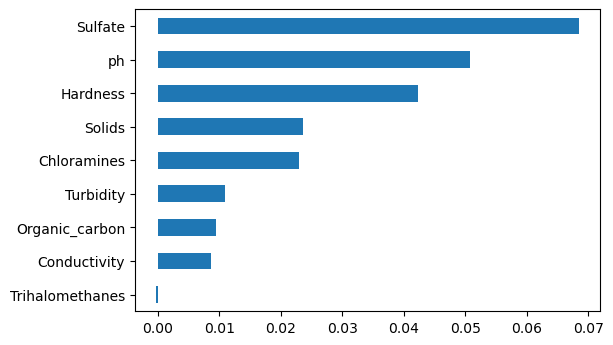

In [ ]:
# 특성 중요도 Random Forest model
# Permutation importance : 하나의 특성을 배제하고 예측했을 때 정확도가 얼마나 떨어지는지
rf_permuter = PermutationImportance(
    rf_tuned,
    scoring='accuracy',
    n_iter=10,
    random_state=42)

rf_permuter.fit(Xt_test, y_test);
pd.Series(rf_permuter.feature_importances_, features).sort_values().plot(kind='barh');

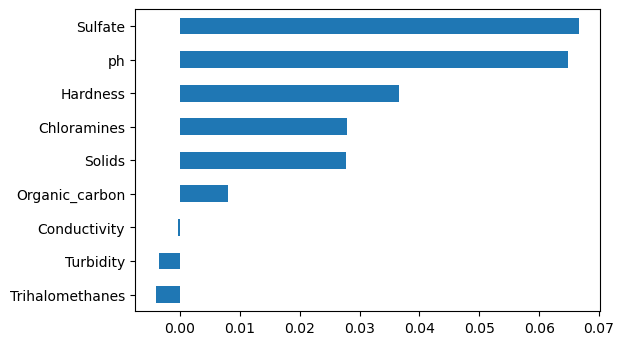

In [ ]:
# 특성 중요도 : XGBoost model
xg_permuter = PermutationImportance(
    xg_tuned,
    scoring='accuracy',
    n_iter=10,
    random_state=42)
xg_permuter.fit(Xt_test, y_test);
pd.Series(xg_permuter.feature_importances_, features).sort_values().plot(kind='barh');

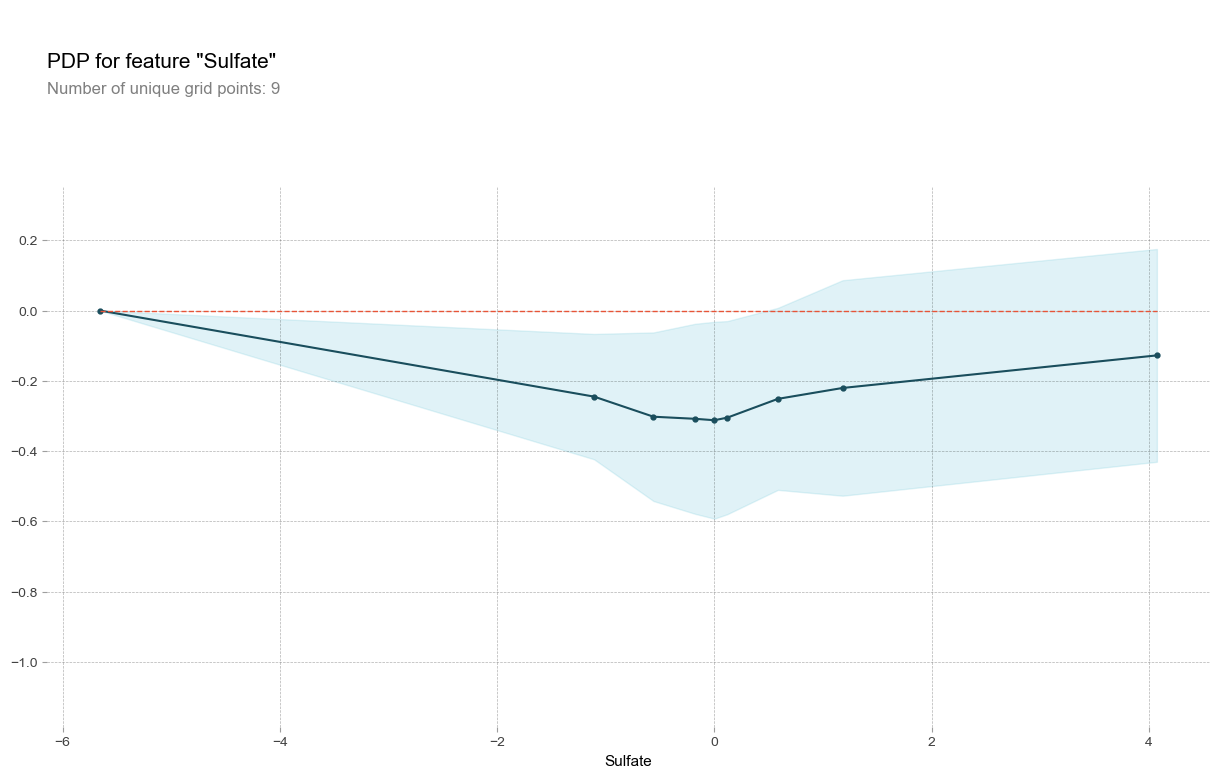

In [ ]:
# PDP Plot -> 나머지 특성은 같고 가정 / 하나의 특성에 따라 예측값이 어떻게 변화하는지
feature='Sulfate' # 황산염
isolated = pdp_isolate(
    model = rf_tuned,
    dataset = Xt_train,
    model_features = features,
    feature = feature)
pdp_plot(isolated, feature_name = feature);

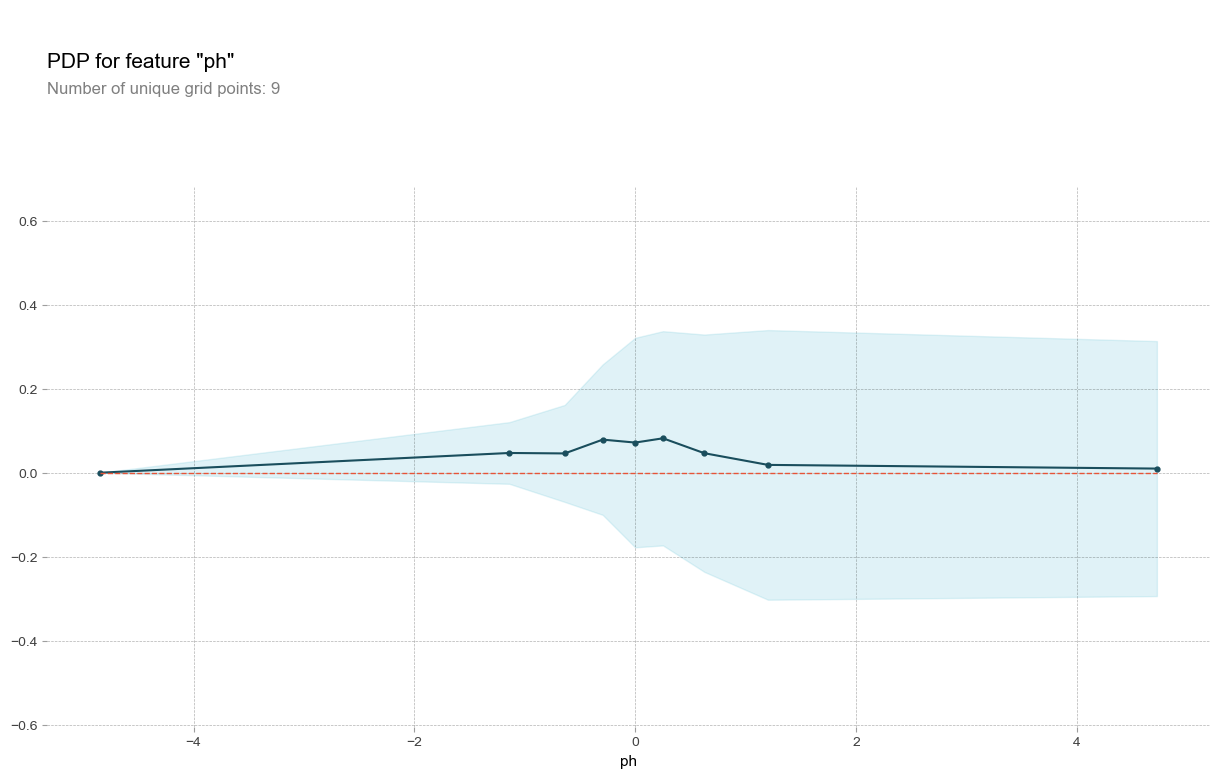

In [ ]:
feature='ph' #수소이온 농도
isolated = pdp_isolate(
    model = rf_tuned,
    dataset = Xt_train,
    model_features = features,
    feature = feature)
pdp_plot(isolated, feature_name = feature);

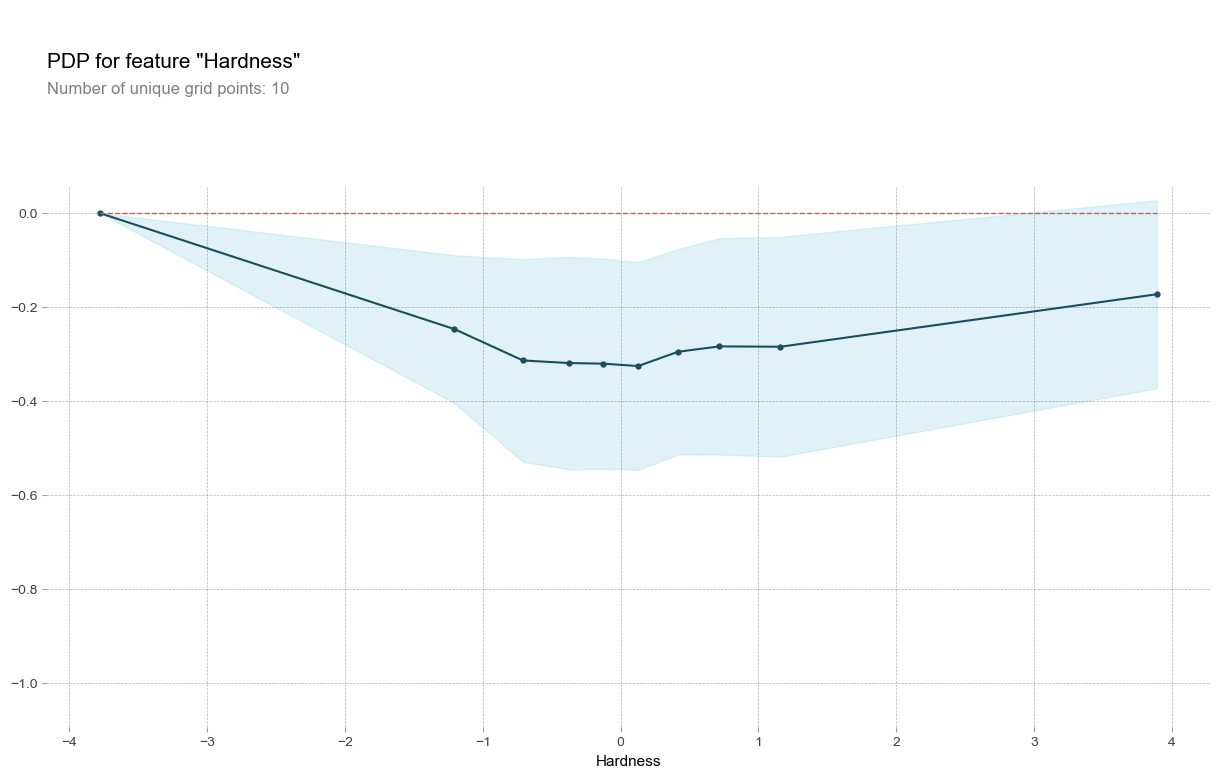

In [ ]:
feature='Hardness' # 수질경도
isolated = pdp_isolate(
    model = rf_tuned,
    dataset = Xt_train,
    model_features = features,
    feature = feature)
pdp_plot(isolated, feature_name = feature);

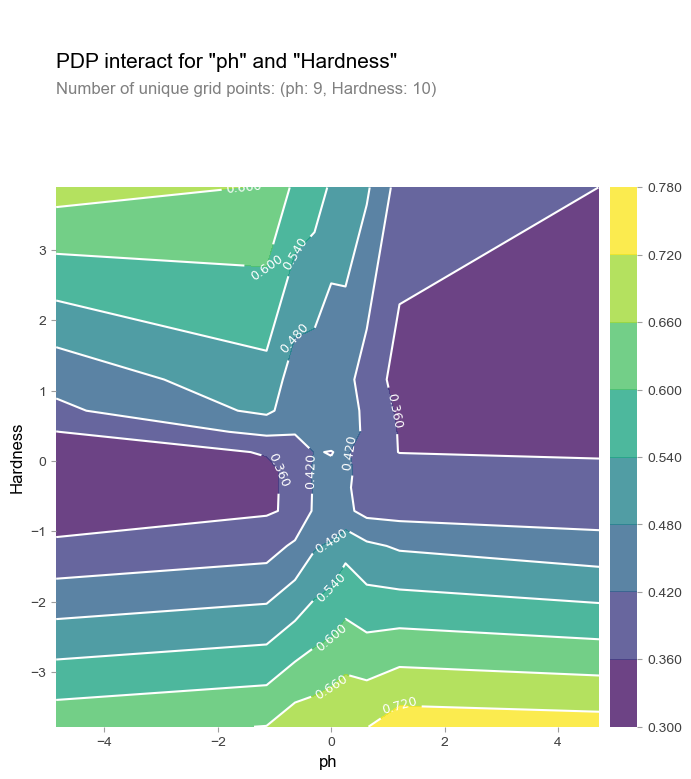

In [ ]:
# 두 특성 간 상호작용이 예측에 미치는 영향
feature = ['ph', 'Hardness']
interact = pdp_interact(
    model = rf_tuned, 
    dataset = Xt_train,
    model_features = features,
    features = feature)
pdp_interact_plot(interact, feature_names=features);

## Conclusion

#### 랜덤포레스트 모델과 XG 부스트 모델을 활용했을 때 68% 수준의 정확도로 예측
#### 모델의 성능은 기대했던 것보다 높지 않음
#### -> 데이터 자체에서 드러나지 않는 부분이 있을 것<br>
#### 예를 들면)<br>
#### 정수과정을 거쳐서 식수가 되는 물 -> 수역이 위치한 지역이나 국가의 기술력, 경제력이 설명력이 있을 것
#### 각 샘플의 단위가 '수역'으로 상당히 넓고 포괄적이라 볼 수 있다.  <br>
#### 한계점 : 데이터셋 자체에서 드러나지 않는 정보가 있을 때  
#### 적절한 추가 데이터를 확보하거나 그런 부분까지 추정할 수 있는 모델로 발전 가능